# Financial Clustering: Predicting Profitability
Understanding the financial health of companies is crucial for investors, analysts, and stakeholders alike. One key metric in assessing a company's performance is its net income, which reflects the profitability of its operations after accounting for all expenses.

The primary focus of this project lies in utilizing unsupervised learning techniques, specifically clustering, to discern patterns within the dataset and identify the most suitable algorithm for predicting whether a company has recorded a net profit or net loss. To facilitate this analysis, we will transform the Net Income column into a binary representation, where a value of 1 signifies profit and 0 denotes loss. By undertaking this transformation, we aim to build a model capable of accurately categorizing companies based on their financial performance.

The dataset for this project is taken from [Kaggle](https://www.kaggle.com/datasets/dgawlik/nyse)

## Aproach
- **Data Collection**: Obtain dataset from Kaggle, comprising financial metrics of NYSE-listed companies from 2012 to 2016.
- **Preprocessing**: Clean data, handle missing values, and ensure consistency in features such as revenue, expenses, assets, liabilities, cash flow, earnings per share (EPS), and various financial ratios.
- **Feature Engineering**: Select pertinent features that could impact profitability, normalize or scale them as needed for uniform representation.
- **Clustering Techniques**: Employ unsupervised learning algorithms like k-means and hierarchical clustering models to uncover inherent patterns within the dataset.
- **Model Evaluation**: Assess algorithmic performance by comparing the clustering results in segregating data points to determine the most effective method for categorizing companies based on their financial performance.
- **Interpretation**: Analyze clustering results to gain insights into the financial characteristics distinguishing profitable companies from those operating at a loss. Examine cluster centroids or medoids to identify key features contributing to profitability.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster import hierarchy

# Mute warnings
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings('ignore', module='sklearn')
pd.options.display.float_format = '{:.2f}'.format #To ensure that only two decimal places are shown

In [2]:
# Read CSV file into a DataFrame
data = pd.read_csv('./fundamentals.csv', sep=',')

# Display the first few rows of the DataFrame
data.head()

,Unnamed: 0,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,0,AAL,2012-12-31,3068000000.00,-222000000.00,-1961000000.00,23.00,-1888000000.00,4695000000.00,53.00,...,7072000000.00,9011000000.00,-7987000000.00,24891000000.00,16904000000.00,24855000000.00,-367000000.00,2012.00,-5.60,335000000.00
1,1,AAL,2013-12-31,4975000000.00,-93000000.00,-2723000000.00,67.00,-3114000000.00,10592000000.00,75.00,...,14323000000.00,13806000000.00,-2731000000.00,45009000000.00,42278000000.00,26743000000.00,0.00,2013.00,-11.25,163022222.22
2,2,AAL,2014-12-31,4668000000.00,-160000000.00,-150000000.00,143.00,-5311000000.00,15135000000.00,60.00,...,11750000000.00,13404000000.00,2021000000.00,41204000000.00,43225000000.00,42650000000.00,0.00,2014.00,4.02,716915422.89
3,3,AAL,2015-12-31,5102000000.00,352000000.00,-708000000.00,135.00,-6151000000.00,11591000000.00,51.00,...,9985000000.00,13605000000.00,5635000000.00,42780000000.00,48415000000.00,40990000000.00,0.00,2015.00,11.39,668129938.54
4,4,AAP,2012-12-29,2409453000.00,-89482000.00,600000.00,32.00,-271182000.00,520215000.00,23.00,...,3184200000.00,2559638000.00,1210694000.00,3403120000.00,4613814000.00,6205003000.00,-27095000.00,2012.00,5.29,73283553.88


In [3]:
data.isnull().sum() #Calculate the count of null values in each column

Unnamed: 0                        0
Ticker Symbol                     0
Period Ending                     0
Accounts Payable                  0
Accounts Receivable               0
                               ... 
Total Revenue                     0
Treasury Stock                    0
For Year                        173
Earnings Per Share              219
Estimated Shares Outstanding    219
Length: 79, dtype: int64

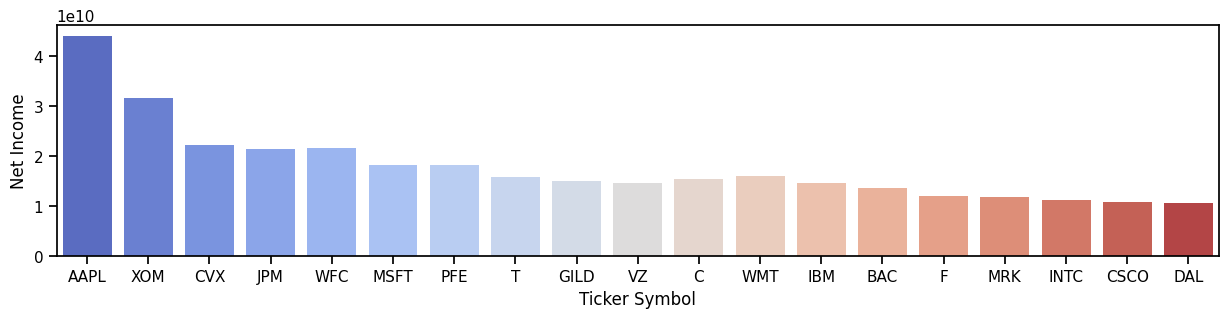

In [4]:
plt.figure(figsize=(15, 3))

# Create the bar plot
data_sort = data.sort_values(by='Net Income', ascending=False).head(50)
sns.set_context("notebook")
sns.barplot(x=data_sort['Ticker Symbol'], y=data['Net Income'], palette="coolwarm", errorbar=None)

plt.show()

## Feature Transformation
- **Drop Irrelevant Columns**: Remove irrelevant columns like 'Unnamed: 0', 'Ticker Symbol', and 'Period Ending' to enhance data relevance, eliminating unnecessary columns to streamline data analysis and improve relevance.
- **Drop Columns with Missing Values**: Remove columns containing missing values to maintain data integrity and accuracy, ensuring that all attributes are numeric and continuous for compatibility with the K-means clustering algorithm.
- **Ensure Numerical and Continuous Columns**: TO ensure compatibility with K-means clustering, transforming the 'Net Income' column into a binary representation to distinguish profit and loss.
- **Transform 'Net Income' into Binary**: Transform the 'Net Income' column into a binary representation to distinguish profit and loss, converting 'Net Income' values into binary format to distinguish between profitability states.
- **Scale and Normalize Data**: Scale and normalize the data to achieve a standard normal distribution for improved clustering accuracy, normalizing the data distribution to enhance clustering accuracy by achieving a standard normal distribution.

In [5]:
data.drop(['Unnamed: 0', 'Ticker Symbol', 'Period Ending'],axis = 1, inplace=True)
data.dropna(axis=1,inplace=True)

data.isnull().sum().all() == 0

True

In [6]:
data['Net Income'] = data['Net Income'].apply(lambda x : 1 if x > 0 else 0)
data['Net Income'].value_counts()

1    1679
0     102
Name: Net Income, dtype: int64

In [7]:
Skew_columns = data.skew().sort_values(ascending=False)
Skew_columns = Skew_columns.loc[Skew_columns > 0.60]

Skew_columns

Pre-Tax ROE                                           18.00
After Tax ROE                                         15.98
Other Operating Activities                            15.83
Minority Interest                                     15.77
Equity Earnings/Loss Unconsolidated Subsidiary        14.91
Accounts Receivable                                   14.46
Common Stocks                                         12.15
Short-Term Debt / Current Portion of Long-Term Debt   11.88
Non-Recurring Items                                   11.80
Long-Term Debt                                        11.36
Interest Expense                                      11.28
Other Liabilities                                     11.07
Short-Term Investments                                10.87
Cash and Cash Equivalents                             10.11
Intangible Assets                                     10.03
Add'l income/expense items                             9.98
Other Current Liabilities               

Log transformations are applied to columns identified earlier with skewness values exceeding 0.75, utilizing the np.log1p() function. This process stabilizes variance and enhances the normality of data distributions, particularly beneficial for skewed datasets. Subsequently, columns containing missing values are removed using dropna(axis=1, inplace=True), ensuring a clean dataset suitable for machine learning tasks. These preprocessing steps are essential for enhancing data quality and facilitating accurate model training.

In [8]:
# The log transformations
for col in Skew_columns.index:
    data[col] = np.log1p(data[col])
    
data.dropna(axis=1,inplace=True)

Standardize the feature columns, excluding 'Net Income', using StandardScaler. This preprocessing step ensures that all features have a similar scale, which is essential for many machine learning algorithms to perform optimally. By standardizing the features, we enhance the model's ability to learn meaningful patterns from the data and improve its overall performance.

In [9]:
sc = StandardScaler()
feature_columns = [x for x in data.columns if x not in 'Net Income']
for col in feature_columns:
    data[col] = sc.fit_transform(data[[col]])

data.head()

,Accounts Payable,After Tax ROE,Capital Expenditures,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,Cost of Revenue,Deferred Asset Charges,Deferred Liability Charges,Effect of Exchange Rate,...,Sale and Purchase of Stock,Short-Term Debt / Current Portion of Long-Term Debt,Short-Term Investments,Total Assets,Total Current Assets,Total Current Liabilities,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock
0,0.35,0.30,-0.21,0.24,0.17,0.53,0.42,-0.84,0.58,0.24,...,0.28,0.68,1.48,0.26,0.52,0.60,0.61,0.01,0.84,0.25
1,0.48,1.39,-0.63,0.51,0.17,-0.11,0.43,-0.84,0.73,0.24,...,0.28,0.68,1.57,0.70,0.60,0.65,1.00,0.70,0.90,0.28
2,0.47,2.17,-1.36,0.40,0.17,-0.04,0.49,-0.84,0.71,0.24,...,-0.10,0.70,1.54,0.71,0.58,0.65,0.94,0.71,1.28,0.28
3,0.49,2.11,-1.64,0.13,0.17,-0.07,0.43,1.41,0.69,0.24,...,-1.12,0.74,1.54,0.80,0.56,0.65,0.97,0.80,1.25,0.28
4,0.28,0.63,0.33,-0.20,-0.49,-1.41,0.20,-0.84,-1.43,0.24,...,0.27,-0.27,-0.77,-0.96,0.42,0.45,-0.72,-0.96,-0.28,0.28


## Train models

- **Train K-means with two clusters**: Employ the K-means algorithm to split the dataset into two groups based on feature similarity. Iterate over the data, assigning points to clusters and updating centroids until convergence, effectively partitioning the data.
- **Train Agglomerative with two clusters**: Utilize Agglomerative clustering, employing both ward-link and complete-link methods, to create two distinct clusters. Ward-link minimizes the variance within clusters, while complete-link uses the maximum distance between any two points in the clusters to merge.
- **Compare clustering outcomes**: Evaluate the distribution of companies with net profit and net loss across clusters produced by K-means and Agglomerative clustering. Analyze the performance of each method in segregating companies based on their profitability, providing insights into the strengths and limitations of each approach for analyzing financial data.
- **Visualize Agglomerative dendrogram**: Plot the dendrogram, depicting the hierarchical merging of clusters in Agglomerative clustering. This visual representation illustrates the step-by-step clustering process and helps in determining an appropriate number of clusters for the dataset.
<br>
### K-means :

In [10]:
# Fit K-means clustering model
kmeans_model = KMeans(n_clusters=2, random_state=42).fit(data[feature_columns])

# Assign cluster labels to the data
data['kmeans'] = kmeans_model.labels_
cluster_net_income_counts = data.groupby(['kmeans', 'Net Income']).size().reset_index(name='number')

cluster_net_income_counts

,kmeans,Net Income,number
0,0,0,8
1,0,1,295
2,1,0,94
3,1,1,1384


### Agglomerative Clustering :

In [11]:
for linkage in ['complete', 'ward']:
    agglomerative_model = AgglomerativeClustering(n_clusters=2, linkage=linkage, compute_full_tree=True)
    agglomerative_model.fit(data[feature_columns])
    data['agglom_' + linkage] = agglomerative_model.labels_


In [12]:
complete_linkage = (data.groupby(['Net Income', 'agglom_complete']).size().reset_index(name='number'))
complete_linkage

,Net Income,agglom_complete,number
0,0,0,102
1,1,0,1671
2,1,1,8


- For companies with a net income status of 0 (indicating loss), there are 102 data points assigned to Cluster 0.
- For companies with a net income status of 1 (indicating profit), there are 1674 data points assigned to Cluster 0 and 5 data points assigned to Cluster 1.

In [13]:
ward_linkage = data.groupby(['Net Income', 'agglom_ward']).size().reset_index(name='number')
ward_linkage

,Net Income,agglom_ward,number
0,0,0,13
1,0,1,89
2,1,0,323
3,1,1,1356


- For companies with a net income status of 0 (indicating loss), there are 102 data points assigned to Cluster 1.
- For companies with a net income status of 1 (indicating profit), there are 18 data points assigned to Cluster 0 and 1661 data points assigned to Cluster 1.

## Comparing Results

Comparing Agglomerative Clustering (complete and ward linkage) and K-means algorithms by net income status and cluster labels, we calculate counts for each combination. This assesses their effectiveness in segregating data points by net income, offering insights into performance.

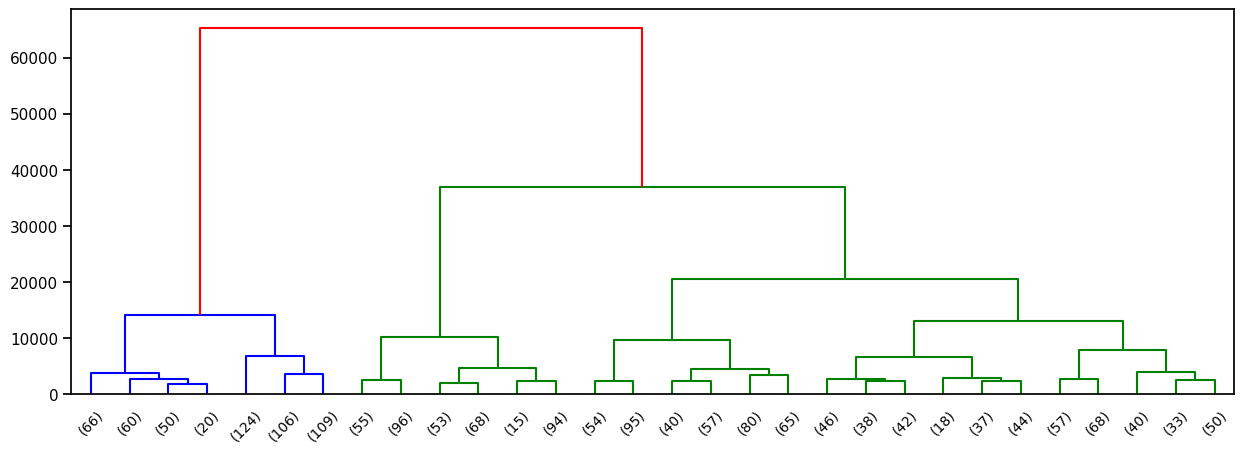

In [14]:
# Perform hierarchical clustering and generate dendrogram
Z = hierarchy.linkage(agglomerative_model.children_, method='ward')

# Create a dendrogram plot
fig, ax = plt.subplots(figsize=(15, 5))
hierarchy.set_link_color_palette(['blue', 'green'])
dendogram = hierarchy.dendrogram(Z, orientation='top', p=30, truncate_mode='lastp', show_leaf_counts=True, ax=ax, above_threshold_color='red')

In [15]:
comparison = (data.groupby(['Net Income', 'agglom_complete', 'agglom_ward', 'kmeans']).size().reset_index(name='number'))
comparison

,Net Income,agglom_complete,agglom_ward,kmeans,number
0,0,0,0,0,8
1,0,0,0,1,5
2,0,0,1,1,89
3,1,0,0,0,287
4,1,0,0,1,28
5,1,0,1,1,1356
6,1,1,0,0,8


## Conclusion
In conclusion, the analysis highlights a notable discrepancy in the accuracy of predicting profit compared to predicting loss, attributed to the substantial disparity in data distribution between profitable and non-profitable companies (1: 1679 vs 0: 102). The **Complete-link Agglomerative Clustering model demonstrates superior performance in predicting loss**, while **KMeans Clustering emerges as the optimal choice for predicting profit**, although Ward-link Agglomerative Clustering also yields commendable results.


## Future Developments

To potentially improve results, exploring additional techniques like Principal Component Analysis (PCA) or hyperparameter tuning could be beneficial. PCA and hyperparameter tuning can enhance clustering by reducing dimensionality, mitigating noise, and optimizing algorithm parameters, leading to more accurate and reliable results.